In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [56]:
def generate_data(N):
    X = torch.randint(0, 9, size = (N, 10))
    num2s = torch.count_nonzero(X == 2, dim = -1)
    num4s = torch.count_nonzero(X == 4, dim = -1)
    
    labels = (num4s > num2s)
    
    return X, labels.reshape(-1,1)

In [10]:
X, y = generate_data(123)

In [11]:
X[0]

tensor([2, 4, 7, 4, 1, 0, 2, 5, 4, 1])

In [12]:
y[0]

tensor(True)

In [13]:
X

tensor([[2, 4, 7,  ..., 5, 4, 1],
        [1, 8, 0,  ..., 3, 7, 6],
        [8, 5, 2,  ..., 3, 3, 4],
        ...,
        [5, 0, 7,  ..., 8, 1, 8],
        [4, 2, 4,  ..., 8, 5, 6],
        [5, 7, 5,  ..., 0, 2, 7]])

In [14]:
X.shape

torch.Size([123, 10])

In [16]:
embed_func = torch.nn.Embedding(10, embedding_dim=16)

In [18]:
embedX = embed_func(X); print(embedX.shape)

torch.Size([123, 10, 16])


In [19]:
query = torch.nn.Parameter(torch.randn(1,16))
query

Parameter containing:
tensor([[-1.1265, -0.0911, -1.3967,  0.4953, -1.3869, -0.7703,  1.0596,  0.1395,
          0.7398, -0.0186,  0.2040,  0.3268,  0.4368, -1.2872, -0.5836, -0.2980]],
       requires_grad=True)

In [22]:
key_func = torch.nn.Linear(16,16)

In [23]:
keys = key_func(embedX)
keys.shape

torch.Size([123, 10, 16])

$$
Att_{bij} = \text{Softmax}(\frac{q_{ie} K_{bje}}{\sqrt{d}})
$$

* $i$ : The number of questions
* $e$ : The number of embedding features

In [36]:
qk = torch.einsum('ie, bje -> bij', query, keys)
qk = qk / 16**0.5

att = torch.nn.functional.softmax(qk, dim=-1)
att.shape

torch.Size([123, 1, 10])

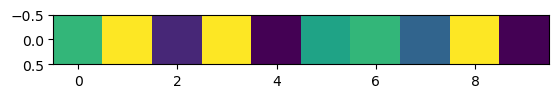

In [34]:
plt.imshow(att[0].detach())
plt.show()

In [41]:
value_func = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1)
)

head_mlp = torch.nn.Sequential(
    torch.nn.Linear(1,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)

In [35]:
vals = value_func(embedX)
vals.shape

torch.Size([123, 10, 1])

In [38]:
summary = torch.einsum('bij, bje -> bie', att, vals)[:,0,:]

In [40]:
summary.shape

torch.Size([123, 1])

In [43]:
pred = head_mlp(summary)

In [44]:
pred.shape

torch.Size([123, 1])

In [57]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query = torch.nn.Parameter(torch.randn(1,16))
        self.embed_func = torch.nn.Embedding(10, embedding_dim=16)
        self.key_func = torch.nn.Linear(16,16)
        self.value_func = torch.nn.Sequential(
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,1)
        )

        self.head_mlp = torch.nn.Sequential(
            torch.nn.Linear(1,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, X):
        embedX = self.embed_func(X)
        keys = self.key_func(embedX)
        qk = torch.einsum('ie, bje -> bij', self.query, keys)
        qk = qk / 16 ** 0.5
        att = torch.nn.functional.softmax(qk, dim = -1)
        vals = self.value_func(embedX)
        summary = torch.einsum('bij, bje -> bie', att, vals)[:,0,:]
        
        pred = self.head_mlp(summary)
        return pred, att, vals

In [58]:
model = AttentionModel()

X, y = generate_data(123)
p, a, y = model(X)

loss = torch.nn.functional.binary_cross_entropy(p,y)
loss

ValueError: Using a target size (torch.Size([123, 10, 1])) that is different to the input size (torch.Size([123, 1])) is deprecated. Please ensure they have the same size.